In [1]:
import pandas as pd
from outcome_distribution import outcome_distribution_builder
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict

# 0 Load the enriched case log

In [2]:
INPUT_FILE_NAME = 'cases_rtfm_full.csv' # the enriched event log
CASE_ID_COL = 'case:concept:name'
TIMESTAMP_COL = 'time:timestamp'
ACTIVITY_COL = 'concept:name'

In [3]:
# read the enriched case log csv into a dataframe
df = pd.read_csv(INPUT_FILE_NAME,  dtype={'org:resource': str, 'matricola': str})
print(len(df), 'rows read from', INPUT_FILE_NAME)
df.head()

C:\Users\Timot\AppData\Local\Temp\ipykernel_63712\1999305717.py:2: DtypeWarning: Columns (45,46,47,51,59,63,70,74,94,99,106,110,117,118,122,129,133,140,144,152,153,158,165,170,177,182,189,194,201,206,213,218,225,230,237,242,249,254,261,266,273,278,285,290,297,302,309,314) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_FILE_NAME,  dtype={'org:resource': str, 'matricola': str})


150370 rows read from cases_rtfm_full.csv


,case_id,Create Fine.count,event_count,start_time,start_time_rel,duration,Create Fine.start,Create Fine.amount,Create Fine.org:resource,Create Fine.dismissal,...,Payment:Create Fine.delay,paid_full,dismissed,credit_collection,unresolved,appeal,overturned_judge,overturned_prefecture,overturned,upheld
0,S38735,1,5,2000-01-01,0,830,0,62.59,18,NIL,...,NaN,False,False,True,False,False,False,False,False,False
1,S44306,1,5,2000-01-02,1,464,0,62.59,704,NIL,...,NaN,False,False,True,False,False,False,False,False,False
2,S49055,1,6,2000-01-02,1,239,0,31.30,35,NIL,...,-104.0,False,False,False,True,False,False,False,False,False
3,S49056,1,5,2000-01-02,1,829,0,31.30,35,NIL,...,NaN,False,False,True,False,False,False,False,False,False
4,S49057,1,5,2000-01-02,1,829,0,31.30,35,NIL,...,NaN,False,False,True,False,False,False,False,False,False


# 1 Visualize the Outcome Distribution

In [4]:
#define the list of predicates
lst_of_predicates = [(lambda row: row["Final.outstanding_balance"] <= 0.0), # predicate for Fully Paid
                      (lambda row: row["Send for Credit Collection.count"] >= 1), # predicate for Collected
                      (lambda row: row["Final.dismissal::last"] in ['G', '#']) # predicate for Dismissed
                    ]
#define the labels of the outcomes
outcomes_labels = ["Fully Paid", "Collected", "Dismissed"]

In [5]:
#compute the values for the outcome distribution and check for overlaps between the outcomes
values, dct = outcome_distribution_builder(df, outcomes_labels, lst_of_predicates)

{'Fully Paid': [('Collected', 3), ('Dismissed', 1)], 'Collected': [('Dismissed', 0)]}


Here we can see that there are 3 cases that co-occur between Fully Paid and Collected and 1 case that co-occurs in Fully Paid and Dismissed. Therefore, we can choose to remove these duplicate cases from the final outcome distribution. In our case we remove 4 cases from Fully Paid, 3 cases from Collected and 1 case from Dismissed bellow

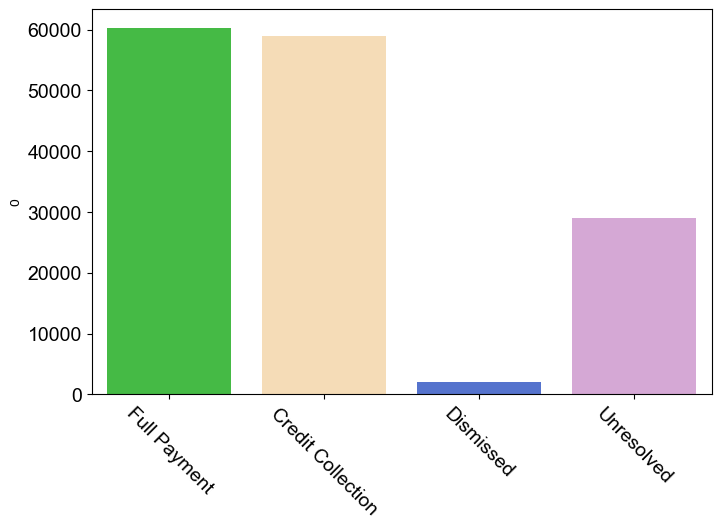

In [6]:
#Create a dictionary with the colors for each variable
colors = {"Full Payment": "limegreen", "Dismissed": "royalblue", "Credit Collection": "navajowhite", "Unresolved": "plum"}
# Create a pandas DataFrame with your data
data = {"Full Payment": [values[0][0] -4],  "Credit Collection": [values[1][0] -3], "Dismissed": [values[2][0] -1], "Unresolved": [values[3][0]]}
df_bar = pd.DataFrame(data)
# Create the bar chart
plt.figure(figsize=(8, 5))
sns.barplot(y = df_bar.iloc[0], x=df_bar.columns, palette=colors)
# Set the background color
sns.set_style("whitegrid")
# change font size of y axis and x axis
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(rotation=-45)
plt.show()